####                       The Battle of the Neighborhoods 
####          Applied Data Science Capstone- Capstone Project
####                                      Jhonny Calvo
### Proposal for Opening a Bar-Restaurant in Caracas City.


## PART 1
Exploring and clustering the data


###  Importing necessary libraries

In [1]:
import pandas as pd # library to handle data in a vectorized manner
import numpy as np # library for data analsysis
import re

from bs4 import BeautifulSoup as bs # library for web scraping
import requests # Library for web scraping

!pip install lxml

print('Libraries imported.')

Libraries imported.


In [2]:
# library for maps
!conda install -c conda-forge folium --yes 
import folium # map rendering library

print('Ready!')

Solving environment: done

# All requested packages already installed.

Ready!


In [3]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
print('Libraries imported!')

Libraries imported!


In [4]:
# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported!')

Libraries imported!


### Downloading Caracas Neighborhoods and Coordinates

In [5]:
source=requests.get('https://www.antipodas.net/coordenadaspais/venezuela/caracas.php').text
soup=bs(source,'lxml')
article=soup.find('table')

#### Creating Dataframe with Neighborhoods and its coordinates

In [6]:
to_table=article.find_all('tr') 
table=[]
for row in to_table:
    table.append([t.text.strip() for t in row.find_all('td')]) #take every row values from web table
    
df = pd.DataFrame(table, columns=('Neighborhood','Distance','Coordinates')) #Create Dataframe with selected columns from table
df = df.drop([0,0], axis=0)
df.head()

,Neighborhood,Distance,Coordinates
1,Parroquia San Pedro,1 Km,"N10°29'20.36"" O66°53'20.29"""
2,Parroquia El Recreo,2 Km,"N10°30'18.11"" O66°53'15.83"""
3,Chacao,3 Km,"N10°29'45.53"" O66°51'12.49"""
4,Parroquia Candelaria,3 Km,"N10°30'21.46"" O66°54'17.78"""
5,Parroquia San Agustín,3 Km,"N10°29'38.76"" O66°54'36.94"""


#### Cleaning and data ordering

In [7]:
df['Coord']=df.Coordinates.str.split(' ')
df[['Lat','Long']]=pd.DataFrame(df.Coord.values.tolist(), index= df.index)
df.drop(columns=['Coord','Distance','Coordinates'],axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Neighborhood,Lat,Long
0,Parroquia San Pedro,"N10°29'20.36""","O66°53'20.29"""
1,Parroquia El Recreo,"N10°30'18.11""","O66°53'15.83"""
2,Chacao,"N10°29'45.53""","O66°51'12.49"""
3,Parroquia Candelaria,"N10°30'21.46""","O66°54'17.78"""
4,Parroquia San Agustín,"N10°29'38.76""","O66°54'36.94"""


#### Converting coordinates DMS to decimal numbers DD

In [8]:
def convert(coord):
    part = re.split('[^0-9]', coord)
    direction=re.split('\d',coord)
    coordd=float(part[1])+ float(part[2])/60 + (float(part[3])+float(part[4])/(10))/(60*60)
    if direction[0] == 'S' or direction[0] == 'O':
        coordd *= -1
    return (coordd)

latitude=[]
longitude=[]

for row in df['Lat']:
    x=convert(row)
    latitude.append(x)

for row in df['Long']:
    x=convert(row)
    longitude.append(x) 
      
# Create a zipped list of tuples from above lists
zippedList =  list(zip(latitude,longitude))

In [9]:
#columns=('Latitude','Longitude')
df[['Latitude','Longitude']]=pd.DataFrame(zippedList)
df.drop(columns=['Lat','Long'],axis=0, inplace=True)

In [10]:
baruta2={'Neighborhood':'Las Mercedes','Latitude':10.480556,'Longitude':-66.861111}
df=df.append(pd.Series(['Las Mercedes', 10.480556, -66.861111], index=df.columns), ignore_index=True)
df.head()

,Neighborhood,Latitude,Longitude
0,Parroquia San Pedro,10.489889,-66.889694
1,Parroquia El Recreo,10.505306,-66.889806
2,Chacao,10.497306,-66.854694
3,Parroquia Candelaria,10.507111,-66.906889
4,Parroquia San Agustín,10.496000,-66.912611


### Defining the coordinates of the neighborhood

In [11]:
neighborhood_latitude = df.loc[4, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[4, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[4, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parroquia San Agustín are 10.495999999999999, -66.91261111111112.


Let's Map

In [12]:
# create map of New York using latitude and longitude values
map_ccs = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=12)

# add markers to map
for lat, lng, Neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ccs)  
    
map_ccs

### Defining Foursquare Credentials and Version 

In [13]:
CLIENT_ID = 'USDIHUTTFPQNVC1DB410W3T25VTUDQEFMSE2YPEISSOQAKBK' # your Foursquare ID
CLIENT_SECRET = 'OS3US4HDDQBN0ZA03I4YSED53YMUROHWW32GSEAFPHHH4C1X' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: USDIHUTTFPQNVC1DB410W3T25VTUDQEFMSE2YPEISSOQAKBK
CLIENT_SECRET:OS3US4HDDQBN0ZA03I4YSED53YMUROHWW32GSEAFPHHH4C1X


### Using Foursquare, we will define a function to get all values from a selected location, Caracas in this case

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Let's use the above function to get Caracas venues

In [15]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
ccs_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parroquia San Pedro
Parroquia El Recreo
Chacao
Parroquia Candelaria
Parroquia San Agustín
Parroquia San Bernardino
Parroquia Santa Rosalía
Parroquia Catedral
Parroquia Santa Teresa
Parroquia Altagracia
Parroquia El Paraíso
Parroquia San Juan
Parroquia El Valle
Parroquia La Pastora
Parroquia San José
Parroquia 23 de Enero
Baruta
Parroquia Coche
Parroquia La Vega
Parroquia Sucre
Petare
Pueblo el Hatillo
Parroquia Antímano
Parroquia Caricuao
Caricuao
San Antonio de Los Altos
La Guaira
Parroquia Macarao
Carrizal
Parroquia El Junquito
Las Mercedes


### Let's see the results

In [16]:
print(ccs_venues.shape)
print('There are {} uniques categories.'.format(len(ccs_venues['Venue Category'].unique())))
ccs_venues.head()

(739, 7)
There are 145 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parroquia San Pedro,10.489889,-66.889694,Estadio Olímpico Universitario,10.490449,-66.885710,Soccer Stadium
1,Parroquia San Pedro,10.489889,-66.889694,Plaza del Rectorado,10.492148,-66.890817,College Quad
2,Parroquia San Pedro,10.489889,-66.889694,Video San Pedro,10.485993,-66.891776,Video Store
3,Parroquia San Pedro,10.489889,-66.889694,Estadio Universitario de Caracas,10.489607,-66.884255,Baseball Stadium
4,Parroquia San Pedro,10.489889,-66.889694,Plaza Cubierta,10.491076,-66.890764,College Quad


In [17]:
VenueCategory=ccs_venues['Venue Category'].value_counts()
VenueCategory

Bakery                       61
Pharmacy                     38
Plaza                        35
Italian Restaurant           35
Fast Food Restaurant         24
Theater                      20
Chinese Restaurant           20
Coffee Shop                  19
Pizza Place                  18
Café                         18
Restaurant                   18
Gym                          17
Historic Site                13
Steakhouse                   13
Shopping Mall                13
Burger Joint                 13
Sandwich Place               12
Spanish Restaurant           12
Park                         10
History Museum               10
Metro Station                 9
Breakfast Spot                9
Grocery Store                 8
Mediterranean Restaurant      8
Ice Cream Shop                8
Dessert Shop                  8
Middle Eastern Restaurant     7
Trail                         7
Latin American Restaurant     7
Hotel                         7
                             ..
African 

#### Filtering Data to obtein Vanues With Bar

In [18]:
ccs_bar = ccs_venues.loc[
    (ccs_venues["Venue Category"] == 'Bar') |
    (ccs_venues["Venue Category"] == 'Sports Bar') |
    (ccs_venues["Venue Category"] == 'Gay Bar') |
    (ccs_venues["Venue Category"] == 'Nightclub') |
    (ccs_venues["Venue Category"] == 'Disco') |
    (ccs_venues["Venue Category"] == 'Lounge') |
    (ccs_venues["Venue Category"] == 'Speakeasy') |
    (ccs_venues["Venue Category"] == 'Cocktail Bar') |
    (ccs_venues["Venue Category"] == 'Restaurant')|
    (ccs_venues["Venue Category"] == 'Italian Restaurant')|
    (ccs_venues["Venue Category"] == 'American Restaurant') |
    (ccs_venues["Venue Category"] == 'Asian Restaurant') |
    (ccs_venues["Venue Category"] == 'Spanish Restaurant') |
    (ccs_venues["Venue Category"] == 'Restarurant') |
    (ccs_venues["Venue Category"] == 'Chinese Restaurant') |
    (ccs_venues["Venue Category"] == 'Pizza Place') |
    (ccs_venues["Venue Category"] == 'Peruvian Restaurant') |
    (ccs_venues["Venue Category"] == 'Sushi Restaurant') |
    (ccs_venues["Venue Category"] == 'Paella Restaurant') |
    (ccs_venues["Venue Category"] == 'Japanese Restaurant') |
    (ccs_venues["Venue Category"] == 'Tapas Restaurant') |
    (ccs_venues["Venue Category"] == 'Mexican Restaurant') |
    (ccs_venues["Venue Category"] == 'Mediterranean Restaurant') |
    (ccs_venues["Venue Category"] == 'French Restaurant') |
    (ccs_venues["Venue Category"] == 'Middle Eastern Restaurant') |
    (ccs_venues["Venue Category"] == 'Latin American Restaurant') |
    (ccs_venues["Venue Category"] == 'South American Restaurant') |
    (ccs_venues["Venue Category"] == 'Steakhouse') |
    (ccs_venues["Venue Category"] == 'Salad Place') |
    (ccs_venues["Venue Category"] == 'Hotel Bar')
]
ccs_bar.shape

(186, 7)

In [19]:
ccs_bar_data=ccs_bar[['Neighborhood','Venue Latitude', 'Venue Longitude','Venue Category']]
ccs_bar_data.columns=['Neighborhood','Latitude','Longitude','Venue Category']
ccs_bar_data.reset_index(drop=True, inplace=True)
ccs_bar_data.head()

,Neighborhood,Latitude,Longitude,Venue Category
0,Parroquia San Pedro,10.485208,-66.887299,Pizza Place
1,Parroquia San Pedro,10.492837,-66.882488,Latin American Restaurant
2,Parroquia San Pedro,10.483316,-66.889222,Italian Restaurant
3,Parroquia San Pedro,10.489362,-66.881442,Steakhouse
4,Parroquia San Pedro,10.486382,-66.884774,Nightclub


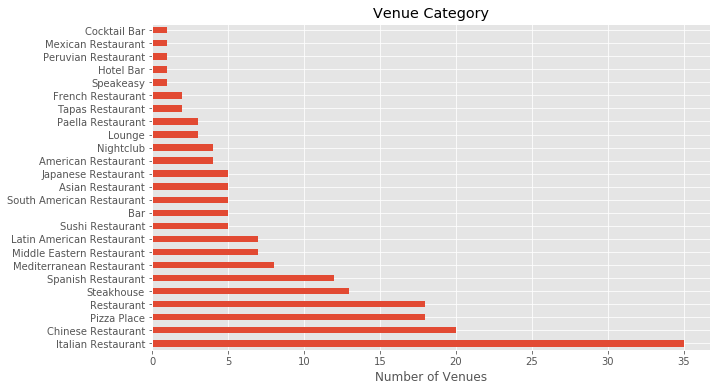

In [87]:
cc_bar_venuefrq=pd.DataFrame(ccs_bar_data['Venue Category'].value_counts())

cc_bar_venuefrq['Venue Category'].plot(kind='barh',
                            figsize=(10, 6),
                           )
plt.xlabel('Number of Venues')
plt.title('Venue Category')
plt.show()

### Where are these bars?

In [21]:
bar_latitude = ccs_bar_data.loc[4, 'Latitude'] # bar latitude value
bar_longitude = ccs_bar_data.loc[4, 'Longitude'] # bar longitude value

ccs_bar_data_name = ccs_bar_data.loc[4, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(ccs_bar_data_name, 
                                                               bar_latitude, 
                                                               bar_longitude))

Latitude and longitude values of Parroquia San Pedro are 10.486381793529814, -66.88477395815744.


In [22]:
# create map of New York using latitude and longitude values
bar_ccs = folium.Map(location=[bar_latitude, bar_longitude], zoom_start=12)

# add markers to map
for lat, lng, Neighborhood in zip(ccs_bar_data['Latitude'], ccs_bar_data['Longitude'], ccs_bar_data['Neighborhood']):
    label = '{}'.format(Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=False,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(bar_ccs)  
    
bar_ccs

## PART 2

###  Analyzing Each Neighborhood

In [23]:
# one hot encoding
ccs_onehot = pd.get_dummies(ccs_bar[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ccs_onehot['Neighborhood'] = ccs_bar['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ccs_onehot.columns[-1]] + list(ccs_onehot.columns[:-1])
ccs_onehot = ccs_onehot[fixed_columns]

ccs_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,Bar,Chinese Restaurant,Cocktail Bar,French Restaurant,Hotel Bar,Italian Restaurant,Japanese Restaurant,...,Paella Restaurant,Peruvian Restaurant,Pizza Place,Restaurant,South American Restaurant,Spanish Restaurant,Speakeasy,Steakhouse,Sushi Restaurant,Tapas Restaurant
9,Parroquia San Pedro,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
10,Parroquia San Pedro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,Parroquia San Pedro,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12,Parroquia San Pedro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19,Parroquia San Pedro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
ccs_onehot.shape

(186, 26)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
ccs_bar_grouped = ccs_onehot.groupby('Neighborhood').mean().reset_index()
ccs_bar_grouped.head()

,Neighborhood,American Restaurant,Asian Restaurant,Bar,Chinese Restaurant,Cocktail Bar,French Restaurant,Hotel Bar,Italian Restaurant,Japanese Restaurant,...,Paella Restaurant,Peruvian Restaurant,Pizza Place,Restaurant,South American Restaurant,Spanish Restaurant,Speakeasy,Steakhouse,Sushi Restaurant,Tapas Restaurant
0,Baruta,0.142857,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.428571,0.000000,...,0.000000,0.00000,0.285714,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.142857
1,Carrizal,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000
2,Chacao,0.071429,0.047619,0.047619,0.023810,0.02381,0.023810,0.02381,0.142857,0.047619,...,0.023810,0.02381,0.095238,0.071429,0.000000,0.023810,0.02381,0.047619,0.000000,0.023810
3,Las Mercedes,0.000000,0.046512,0.069767,0.023256,0.00000,0.023256,0.00000,0.186047,0.046512,...,0.023256,0.00000,0.000000,0.069767,0.000000,0.069767,0.00000,0.162791,0.069767,0.000000
4,Parroquia Altagracia,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.333333,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.333333,0.000000,0.00000,0.000000,0.000000,0.000000


In [26]:
ccs_bar_grouped.shape

(20, 26)

#### Let's print each neighborhood along with the top 5 most common venues

In [27]:
num_top_venues = 5

for hood in ccs_bar_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ccs_bar_grouped[ccs_bar_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Baruta----
                 venue  freq
0   Italian Restaurant  0.43
1          Pizza Place  0.29
2  American Restaurant  0.14
3     Tapas Restaurant  0.14
4         Cocktail Bar  0.00


----Carrizal----
                       venue  freq
0                 Steakhouse   1.0
1        American Restaurant   0.0
2  Middle Eastern Restaurant   0.0
3           Sushi Restaurant   0.0
4                  Speakeasy   0.0


----Chacao----
                      venue  freq
0        Italian Restaurant  0.14
1               Pizza Place  0.10
2       American Restaurant  0.07
3                Restaurant  0.07
4  Mediterranean Restaurant  0.07


----Las Mercedes----
                      venue  freq
0        Italian Restaurant  0.19
1                Steakhouse  0.16
2  Mediterranean Restaurant  0.09
3                       Bar  0.07
4          Sushi Restaurant  0.07


----Parroquia Altagracia----
                       venue  freq
0  South American Restaurant  0.33
1         Italian Restaurant  0.3

#### Let's put that into a *pandas* dataframe
First, let's write a function to sort the venues in descending order.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [29]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ccs_bar_grouped['Neighborhood']

for ind in np.arange(ccs_bar_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ccs_bar_grouped.iloc[ind, :], num_top_venues)



In [30]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Baruta,Italian Restaurant,Pizza Place,Tapas Restaurant,American Restaurant,Spanish Restaurant
1,Carrizal,Steakhouse,Tapas Restaurant,Mediterranean Restaurant,Asian Restaurant,Bar
2,Chacao,Italian Restaurant,Pizza Place,American Restaurant,Restaurant,Mediterranean Restaurant
3,Las Mercedes,Italian Restaurant,Steakhouse,Mediterranean Restaurant,Sushi Restaurant,Spanish Restaurant
4,Parroquia Altagracia,South American Restaurant,Italian Restaurant,Latin American Restaurant,Tapas Restaurant,Mediterranean Restaurant
5,Parroquia Candelaria,Italian Restaurant,Spanish Restaurant,Pizza Place,Restaurant,Chinese Restaurant
6,Parroquia Catedral,Chinese Restaurant,South American Restaurant,Restaurant,Italian Restaurant,Middle Eastern Restaurant
7,Parroquia Coche,Chinese Restaurant,Tapas Restaurant,Mediterranean Restaurant,Asian Restaurant,Bar
8,Parroquia El Paraíso,Chinese Restaurant,Italian Restaurant,South American Restaurant,Restaurant,Tapas Restaurant
9,Parroquia El Recreo,Steakhouse,Spanish Restaurant,Restaurant,Paella Restaurant,Tapas Restaurant


## PART 3

### Cluster Neighborhoods
Run *k*-means to cluster the neighborhood into 3 clusters.

In [31]:
# set number of clusters
kclusters = 7

ccs_bar_grouped_clustering = ccs_bar_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ccs_bar_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([6, 1, 0, 0, 0, 0, 4, 2, 4, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ccs_bar_merged = ccs_bar_data

# merge ccs_bar_merged with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
ccs_bar_merged = ccs_bar_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ccs_bar_merged.tail() # check the last columns!

,Neighborhood,Latitude,Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
181,Las Mercedes,10.485305,-66.854681,Japanese Restaurant,0,Italian Restaurant,Steakhouse,Mediterranean Restaurant,Sushi Restaurant,Spanish Restaurant
182,Las Mercedes,10.480777,-66.855325,Steakhouse,0,Italian Restaurant,Steakhouse,Mediterranean Restaurant,Sushi Restaurant,Spanish Restaurant
183,Las Mercedes,10.485909,-66.854215,Lounge,0,Italian Restaurant,Steakhouse,Mediterranean Restaurant,Sushi Restaurant,Spanish Restaurant
184,Las Mercedes,10.484163,-66.854791,Italian Restaurant,0,Italian Restaurant,Steakhouse,Mediterranean Restaurant,Sushi Restaurant,Spanish Restaurant
185,Las Mercedes,10.484992,-66.855076,Spanish Restaurant,0,Italian Restaurant,Steakhouse,Mediterranean Restaurant,Sushi Restaurant,Spanish Restaurant


In [33]:
ccs_bar_merged['Cluster Labels']= ccs_bar_merged['Cluster Labels'].fillna(0)
ccs_bar_merged['Cluster Labels']= ccs_bar_merged['Cluster Labels'].astype(int)

ccs_bar_merged.fillna(0)
#ccs_bar_merged.astype(int)

ccs_bar_merged.head() 

,Neighborhood,Latitude,Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Parroquia San Pedro,10.485208,-66.887299,Pizza Place,6,Pizza Place,Steakhouse,Chinese Restaurant,Nightclub,Italian Restaurant
1,Parroquia San Pedro,10.492837,-66.882488,Latin American Restaurant,6,Pizza Place,Steakhouse,Chinese Restaurant,Nightclub,Italian Restaurant
2,Parroquia San Pedro,10.483316,-66.889222,Italian Restaurant,6,Pizza Place,Steakhouse,Chinese Restaurant,Nightclub,Italian Restaurant
3,Parroquia San Pedro,10.489362,-66.881442,Steakhouse,6,Pizza Place,Steakhouse,Chinese Restaurant,Nightclub,Italian Restaurant
4,Parroquia San Pedro,10.486382,-66.884774,Nightclub,6,Pizza Place,Steakhouse,Chinese Restaurant,Nightclub,Italian Restaurant


## Results

In [34]:
labels_frq=pd.DataFrame(ccs_bar_merged['Cluster Labels'].value_counts())
labels_frq

,Cluster Labels
0,135
6,23
4,20
2,5
5,1
3,1
1,1


### let's visualize these cluster in pct

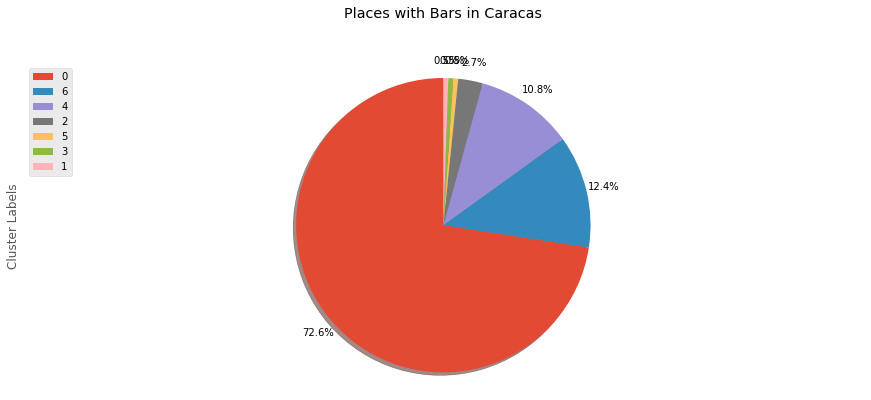

In [35]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
#explode_list = [0.1, 0, 0, 0, 0.1, 0.1] # ratio for each continent with which to offset each wedge.

labels_frq['Cluster Labels'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            )

# scale the title up by 12% to match pctdistance
plt.title('Places with Bars in Caracas', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=labels_frq.index, loc='upper left') 

plt.show()

### Finally, let's visualize the resulting clusters in a map

In [36]:
# create map
map_clusters = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

color2=['red','blue','green','violet']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ccs_bar_merged['Latitude'], ccs_bar_merged['Longitude'], ccs_bar_merged['Neighborhood'], ccs_bar_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        #color=rainbow[cluster-1],
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

### Exploring Cluster '0'

#### Let's explore the 1st Most Common Venue 

In [112]:
cluster0=ccs_bar_merged.loc[ccs_bar_merged['Cluster Labels'] == 0, ccs_bar_merged.columns[[0] + list(range(4, ccs_bar_merged.shape[1]))]]
cluster0.tail()

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
181,Las Mercedes,0,Italian Restaurant,Steakhouse,Mediterranean Restaurant,Sushi Restaurant,Spanish Restaurant
182,Las Mercedes,0,Italian Restaurant,Steakhouse,Mediterranean Restaurant,Sushi Restaurant,Spanish Restaurant
183,Las Mercedes,0,Italian Restaurant,Steakhouse,Mediterranean Restaurant,Sushi Restaurant,Spanish Restaurant
184,Las Mercedes,0,Italian Restaurant,Steakhouse,Mediterranean Restaurant,Sushi Restaurant,Spanish Restaurant
185,Las Mercedes,0,Italian Restaurant,Steakhouse,Mediterranean Restaurant,Sushi Restaurant,Spanish Restaurant


#### How many venues in 1st Mos Common Venues

In [37]:
cluster0_cv=pd.DataFrame(cluster0['1st Most Common Venue'].value_counts())
cluster0_cv

,1st Most Common Venue
Italian Restaurant,125
Steakhouse,7
South American Restaurant,3


#### How is this in pct???

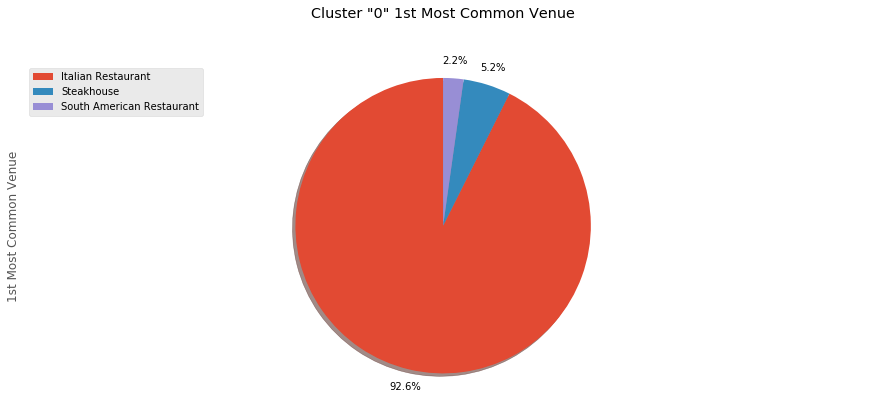

In [38]:
cluster0_cv['1st Most Common Venue'].plot(kind='pie',figsize=(15,6),autopct='%1.1f%%',startangle=90,shadow=True,labels=None,pctdistance=1.12)
plt.title('Cluster "0" 1st Most Common Venue', y=1.12) # scale the title up by 12% to match pctdistance
plt.axis('equal')
plt.legend(labels=cluster0_cv.index, loc='upper left') # add legend 
plt.show()# show plot

#### How many venues per neighborhoods

In [39]:
# How many venues per neighborhoods
cluster0count=cluster0['Neighborhood'].value_counts()
cluster0count

Las Mercedes            43
Chacao                  42
Parroquia Candelaria    30
Parroquia La Vega       10
Parroquia El Recreo      7
Parroquia Altagracia     3
Name: Neighborhood, dtype: int64

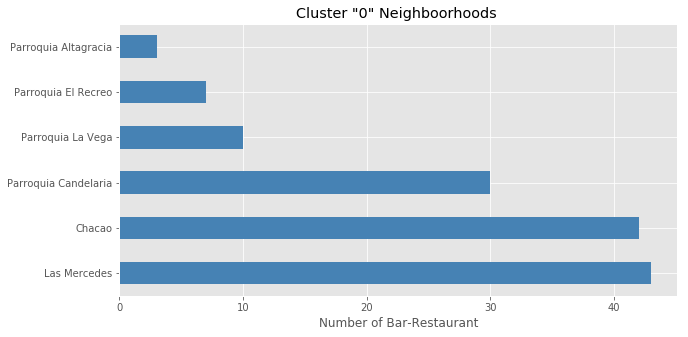

In [86]:
# plot data
cluster0count.plot(kind='barh', figsize=(10, 5), color='steelblue')
plt.title('Cluster "0" Neighboorhoods ') # add title to the plot
plt.xlabel('Number of Bar-Restaurant')
plt.show()

#### Let's explore the 2nd Most Common Venue in cluster '0'

In [115]:
cluster0_2cv=pd.DataFrame(cluster0['2nd Most Common Venue'].value_counts())
cluster0_2cv

,2nd Most Common Venue
Steakhouse,43
Pizza Place,42
Spanish Restaurant,37
Latin American Restaurant,10
Italian Restaurant,3


#### What are the least common venues in cluster 0?

In [122]:
cluster0_5cv=pd.DataFrame(cluster0['5th Most Common Venue'].value_counts())
cluster0_5cv

,5th Most Common Venue
Mediterranean Restaurant,45
Spanish Restaurant,43
Chinese Restaurant,30
Pizza Place,10
Tapas Restaurant,7


### Exploring Cluster '6'

#### Let's explore the 1st Most Common Venue 

In [113]:
cluster6=ccs_bar_merged.loc[ccs_bar_merged['Cluster Labels'] == 6, ccs_bar_merged.columns[[0] + list(range(4, ccs_bar_merged.shape[1]))]]
cluster6.tail()

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
124,Baruta,6,Italian Restaurant,Pizza Place,Tapas Restaurant,American Restaurant,Spanish Restaurant
125,Baruta,6,Italian Restaurant,Pizza Place,Tapas Restaurant,American Restaurant,Spanish Restaurant
126,Baruta,6,Italian Restaurant,Pizza Place,Tapas Restaurant,American Restaurant,Spanish Restaurant
127,Baruta,6,Italian Restaurant,Pizza Place,Tapas Restaurant,American Restaurant,Spanish Restaurant
128,Baruta,6,Italian Restaurant,Pizza Place,Tapas Restaurant,American Restaurant,Spanish Restaurant


#### What is the most common?

In [83]:
cluster6_cv=pd.DataFrame(cluster6['1st Most Common Venue'].value_counts())
cluster6_cv.columns=['Most Common Venue']
cluster6_cv

,Most Common Venue
Italian Restaurant,12
Pizza Place,11


#### Let's explore the 2nd Most Common Venue 

In [125]:
cluster6_2cv=pd.DataFrame(cluster6['2nd Most Common Venue'].value_counts())
cluster6_2cv

,2nd Most Common Venue
Chinese Restaurant,9
Steakhouse,7
Pizza Place,7


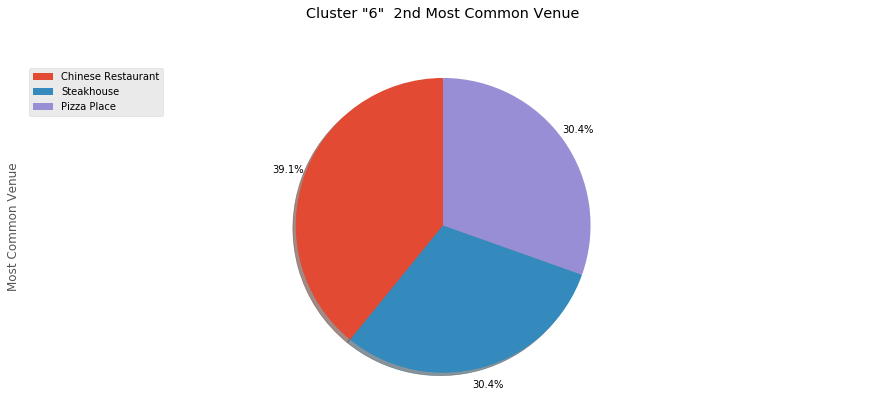

In [123]:
### How is this in pct???
cluster6_2cv['Most Common Venue'].plot(kind='pie',figsize=(15,6),autopct='%1.1f%%',startangle=90,shadow=True,labels=None,pctdistance=1.12)
plt.title('Cluster "6"  2nd Most Common Venue', y=1.12) # scale the title up by 12% to match pctdistance
plt.axis('equal')
plt.legend(labels=cluster6_2cv.index, loc='upper left') # add legend 
plt.show()# show plot

In [52]:
# How many venues per neighborhoods
cluster6count=cluster6['Neighborhood'].value_counts()
cluster6count

Parroquia San Pedro         7
Baruta                      7
Parroquia San Bernardino    5
Parroquia Santa Rosalía     4
Name: Neighborhood, dtype: int64

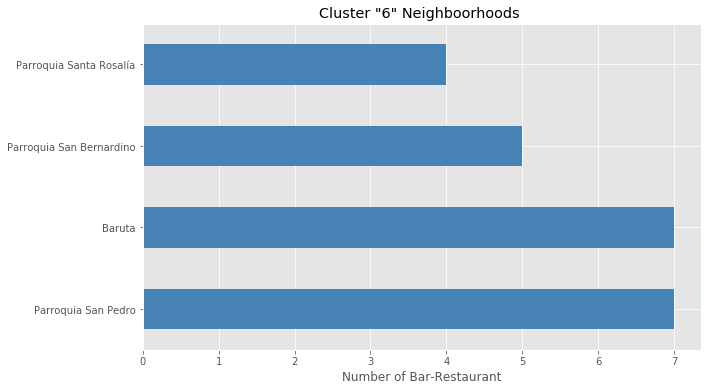

In [60]:
# plot data
cluster6count.plot(kind='barh', figsize=(10, 6), color='steelblue')
plt.title('Cluster "6" Neighboorhoods ') # add title to the plot
plt.xlabel('Number of Bar-Restaurant')
plt.show()

### Exploring Cluster '4'

#### Let's explore the 1st and 2nd Most Common Venue 

In [126]:
cluster4=ccs_bar_merged.loc[ccs_bar_merged['Cluster Labels'] == 4, ccs_bar_merged.columns[[0] + list(range(4, ccs_bar_merged.shape[1]))]]
cluster4_cv=pd.DataFrame(cluster4['1st Most Common Venue'].value_counts())
cluster4_cv

,1st Most Common Venue
Chinese Restaurant,20


In [127]:
cluster4_2cv=pd.DataFrame(cluster4['2nd Most Common Venue'].value_counts())
cluster4_2cv

,2nd Most Common Venue
South American Restaurant,8
Italian Restaurant,7
Restaurant,5


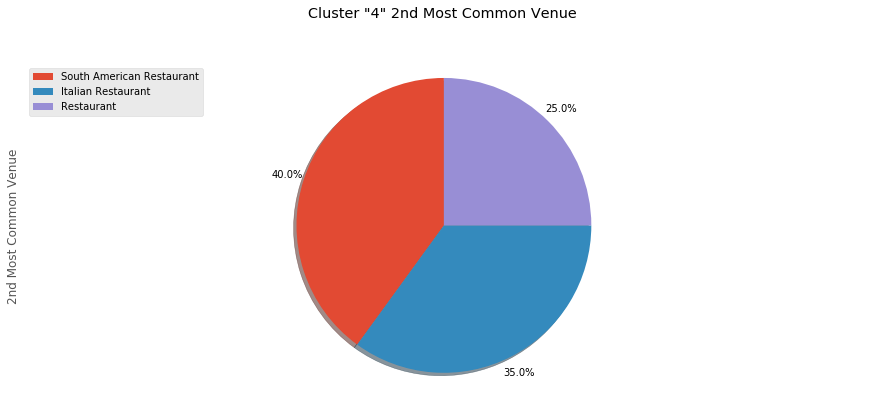

In [129]:
### How is this in pct???
cluster4_2cv['2nd Most Common Venue'].plot(kind='pie',figsize=(15,6),autopct='%1.1f%%',startangle=90,shadow=True,labels=None,pctdistance=1.12)
plt.title('Cluster "4" 2nd Most Common Venue', y=1.12) # scale the title up by 12% to match pctdistance
plt.axis('equal')
plt.legend(labels=cluster4_2cv.index, loc='upper left') # add legend 
plt.show()# show plot

In [94]:
# How many venues per neighborhoods
cluster4count=cluster4['Neighborhood'].value_counts()
cluster4count

Parroquia El Paraíso      7
Parroquia San Agustín     5
Parroquia Catedral        5
Parroquia Santa Teresa    3
Name: Neighborhood, dtype: int64

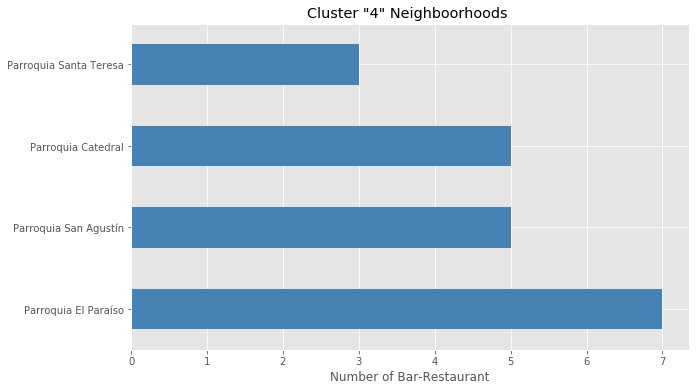

In [95]:
# plot data
cluster4count.plot(kind='barh', figsize=(10, 6), color='steelblue')
plt.title('Cluster "4" Neighboorhoods ') # add title to the plot
plt.xlabel('Number of Bar-Restaurant')
plt.show()

### What about the Clusters 1, 2, 3 and 5??

In [131]:
cluster5=ccs_bar_merged.loc[ccs_bar_merged['Cluster Labels'] == 5, ccs_bar_merged.columns[[0] + list(range(4, ccs_bar_merged.shape[1]))]]
cluster3=ccs_bar_merged.loc[ccs_bar_merged['Cluster Labels'] == 3, ccs_bar_merged.columns[[0] + list(range(4, ccs_bar_merged.shape[1]))]]
cluster2=ccs_bar_merged.loc[ccs_bar_merged['Cluster Labels'] == 2, ccs_bar_merged.columns[[0] + list(range(4, ccs_bar_merged.shape[1]))]]
cluster1=ccs_bar_merged.loc[ccs_bar_merged['Cluster Labels'] == 1, ccs_bar_merged.columns[[0] + list(range(4, ccs_bar_merged.shape[1]))]]

#df_new = pd.concat([cluster5_cv, cluster3_cv, cluster1_cv])
df_new = pd.concat([cluster5, cluster3,cluster2,cluster1])
df_new

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
140,Petare,5,Pizza Place,Tapas Restaurant,Mediterranean Restaurant,Asian Restaurant,Bar
141,Pueblo el Hatillo,3,Middle Eastern Restaurant,Tapas Restaurant,Mediterranean Restaurant,Asian Restaurant,Bar
118,Parroquia San Juan,2,Chinese Restaurant,Tapas Restaurant,Mediterranean Restaurant,Asian Restaurant,Bar
119,Parroquia San Juan,2,Chinese Restaurant,Tapas Restaurant,Mediterranean Restaurant,Asian Restaurant,Bar
120,Parroquia San Juan,2,Chinese Restaurant,Tapas Restaurant,Mediterranean Restaurant,Asian Restaurant,Bar
121,Parroquia El Valle,2,Chinese Restaurant,Tapas Restaurant,Mediterranean Restaurant,Asian Restaurant,Bar
129,Parroquia Coche,2,Chinese Restaurant,Tapas Restaurant,Mediterranean Restaurant,Asian Restaurant,Bar
142,Carrizal,1,Steakhouse,Tapas Restaurant,Mediterranean Restaurant,Asian Restaurant,Bar
